# Generative Adversarial Network for Stock Price Generation

In [4]:
import tensorflow as tf
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
#The data comes from China stock index from 2005 to 2019 on a 1 minute level
df = pd.read_csv('000300_2005_2019_1m.csv')
df.head()

,Unnamed: 0,open,close,high,low,volume,money
0,2005-04-08 09:31:00,984.66,983.83,984.66,983.66,19930000.0,214853842.0
1,2005-04-08 09:32:00,983.85,984.79,984.79,983.85,6780000.0,73091272.0
2,2005-04-08 09:33:00,984.50,984.84,984.86,984.44,4680000.0,27809568.0
3,2005-04-08 09:34:00,984.93,985.55,985.67,984.83,6150000.0,27162392.0
4,2005-04-08 09:35:00,985.64,986.37,986.37,985.64,6520000.0,27208928.0


In [9]:
#We consider only the return series
C = np.array(df['close'])
Ret = (C[1:]-C[:-1])/C[:-1]

In [10]:
N = len(Ret)
N

818879

In [11]:
#The backward looking condition vector include 25 previous returs and the forward looking prediction vector is also 25 returns
l = 25
X_cond = np.array([Ret[i:i+2*l] for i in range(N-2*l+1)])

In [12]:
X_cond.shape

(818830, 50)

In [13]:
train_size=int(N*0.5)

In [14]:

X_train_cond = X_cond[:train_size,:]
X_test_cond = X_cond[train_size:,:]
X_train_cond.shape

(409439, 50)

In [15]:
#helper function to plot returns as a stock price time series starting at 1
def cum_ret(r,past = []):
    if len(past)>0:
        r = np.array(list(past)+list(r))
    l=len(r)
    ts = np.ones(l+1)
    for i in range(l):
        ts[i+1:]*=(1+r[i])
    return ts

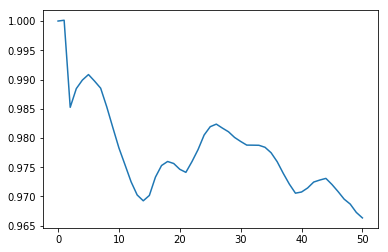

In [16]:
# A random sample path from the training data
randomNum = random.randint(0,train_size)
r = X_train_cond[randomNum]
ts=cum_ret(r)
plt.plot(ts)
plt.show()

# Discriminator Network

In [5]:
#The discriminator takes in a conditional vector w and an input vector x, outputs a scalar value indicating the likelihood of data 
#belonging to true distribution conditioned on the previous returns w
def discriminator(x,w, reuse=False):
    with tf.variable_scope('discriminator') as scope:
        if (reuse):
            tf.get_variable_scope().reuse_variables()
        

        #First Fully Connected Layer
        W_fc11 = tf.get_variable('d_wfc11', [l, 32], initializer=tf.truncated_normal_initializer(stddev=0.01))
        W_fc12 = tf.get_variable('d_wfc12', [l, 32], initializer=tf.truncated_normal_initializer(stddev=0.01))
        b_fc1 = tf.get_variable('d_bfc1', [32], initializer=tf.constant_initializer(0))
        h_fc1 = tf.nn.relu(tf.matmul(w, W_fc11)+tf.matmul(x, W_fc12) + b_fc1)

        #Second Fully Connected Layer
        W_fc2 = tf.get_variable('d_wfc2', [32, 1], initializer=tf.truncated_normal_initializer(stddev=0.01))
        b_fc2 = tf.get_variable('d_bfc2', [1], initializer=tf.constant_initializer(0))

        #Final Layer
        y=tf.nn.relu(tf.matmul(h_fc1, W_fc2) + b_fc2)
    return y

# Generator Network

In [6]:
#The generator takes in the conditions w, which are previous returns, and a random vector z as the seed, outputs return vector y as the predicted returns
def generator(z,w,reuse=False):
    with tf.variable_scope('generator') as scope:
        if (reuse):
            tf.get_variable_scope().reuse_variables()
        
        W_fc11 = tf.get_variable('g_wfc11', [l, 32], initializer=tf.truncated_normal_initializer(stddev=0.005))
        W_fc12 = tf.get_variable('g_wfc12', [l, 32], initializer=tf.truncated_normal_initializer(stddev=0.005))
        b_fc1 = tf.get_variable('g_bfc1', [32], initializer=tf.constant_initializer(0))
        h_fc1 = tf.nn.relu(tf.matmul(w, W_fc11) + tf.matmul(z, W_fc12)+b_fc1)

        #Second Fully Connected Layer
        W_fc2 = tf.get_variable('g_wfc2', [32, l], initializer=tf.truncated_normal_initializer(stddev=0.005))
        b_fc2 = tf.get_variable('g_bfc2', [l], initializer=tf.constant_initializer(0))
        y=tf.nn.tanh(tf.matmul(h_fc1, W_fc2) + b_fc2)

    return y

## Generating a Sample Time Series

In [13]:
sess = tf.Session()
z_test_placeholder = tf.placeholder("float", [10,l])
w_test_placeholder = tf.placeholder("float", [10,l])

In [14]:
sample_image = generator(z_test_placeholder,w_test_placeholder)
test_z = np.random.normal(0, 1, [10,l])

In [15]:
test_w = X_train_cond[randomNum:randomNum+10,:l]
sess.run(tf.global_variables_initializer())
temp = (sess.run(sample_image, feed_dict={z_test_placeholder: test_z,w_test_placeholder: test_w}))

Finally, we can view the output through matplotlib. 

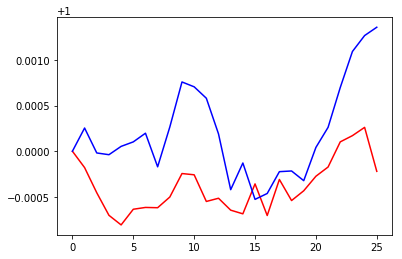

In [16]:
my_i = temp.squeeze()
plt.plot(cum_ret(my_i[5]),'r')
plt.plot(cum_ret(X_train_cond[randomNum+5,l:]),'b')
plt.show()

# Training a GAN

In [17]:
batch_size = 64
tf.reset_default_graph() 

sess = tf.Session()
x_placeholder = tf.placeholder("float", shape = [None,l]) #Placeholder for input data vector to the discriminator
z_placeholder = tf.placeholder(tf.float32, [None, l]) #Placeholder for input noise vectors to the generator
w_placeholder = tf.placeholder(tf.float32, [None, l]) #Placeholder for input condition vectors to both discriminator and generator

In [18]:
Dx = discriminator(x_placeholder,w_placeholder) #Dx will hold discriminator outputs (unnormalized) for the real data
Gz = generator(z_placeholder,w_placeholder) #Gz holds the generated data
Dg = discriminator(Gz,w_placeholder,reuse=True) #Dg will hold discriminator outputs (unnormalized) for generated data

In [19]:
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.ones_like(Dg)))  

In [20]:
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dx, labels=tf.ones_like(Dx)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.zeros_like(Dg)))
d_loss = d_loss_real + d_loss_fake

In [21]:
tvars = tf.trainable_variables()
d_vars = [var for var in tvars if 'd_' in var.name]
g_vars = [var for var in tvars if 'g_' in var.name]

In [22]:
with tf.variable_scope(tf.get_variable_scope(), reuse=False):
    trainerD = tf.train.AdamOptimizer().minimize(d_loss, var_list=d_vars)
    trainerG = tf.train.AdamOptimizer().minimize(g_loss, var_list=g_vars)

In [23]:
sess.run(tf.global_variables_initializer())
iterations = 6000
for i in range(iterations):
    z_batch = np.random.normal(0, 1, size=[batch_size, l])
    real_data_batch = X_train_cond[i*batch_size:(i+1)*batch_size,l:]
    real_cond_batch = X_train_cond[i*batch_size:(i+1)*batch_size,:l]
    
    _,dLoss = sess.run([trainerD, d_loss],feed_dict={z_placeholder:z_batch,x_placeholder:real_data_batch,w_placeholder:real_cond_batch}) #Update the discriminator
    _,gLoss = sess.run([trainerG,g_loss],feed_dict={z_placeholder:z_batch,w_placeholder:real_cond_batch}) #Update the generator 

## Sample a time series from test data and compare the generated path with the original one

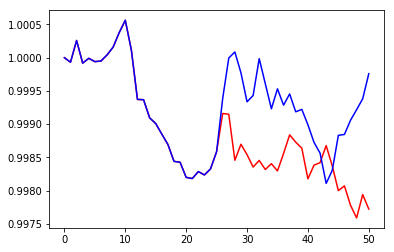

In [29]:
rN = random.randint(0,len(X_test_cond))
test_z = generator(z_placeholder,w_placeholder,reuse=True)
z_batch = np.random.normal(0, 1, size=[1,l])
test_cond = X_test_cond[rN:rN+1,:l]
test_y = X_test_cond[rN,l:]
temp = (sess.run(test_z, feed_dict={z_placeholder: z_batch,w_placeholder: test_cond}))
my_i = temp.squeeze()
plt.plot(cum_ret(my_i,past=test_cond[0]),'r')
plt.plot(cum_ret(test_y,past=test_cond[0]),'b')

In [1]:
from tensorflow.python.summary.writer.writer import FileWriter

In [23]:
FileWriter('logs/train_D', graph=trainerD.graph).close()
%tensorboard --logdir logs/train_D

UsageError: Line magic function `%tensorboard` not found.
